In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.random import split
from einops import rearrange, repeat


In [28]:
def ret_parallel_forward(q, k, v, state=None):
    # q, k, v: B, H, T, D
    B, H, T, D = q.shape
    mask = torch.tril(torch.ones(T, T, dtype=bool)) # causal masking
    attn = mask*(q@k.mT)
    out = attn@v 
    state_n = k.mT @ v
    if state is not None:
        out = out + q @ state
        state_n = state_n + state
    return out, state_n
def ret_recurrent_forward(q, k, v, state=None):
    # q, k, v: B, H, 1, D
    # state: B, H, D, D
    B, H, _, D = q.shape
    if state is None:
        state = torch.zeros(B, H, D, D)
    state = state + k.mT * v # B, H, D, D
    out = q@state
    return out, state

torch.manual_seed(0)
b, h, t, d = 16, 12, 100, 32
q, k, v = torch.randn(b, h, t, d), torch.randn(b, h, t, d), torch.randn(b, h, t, d)

# ------ PARALLEL FORWARD ------ 
out1, _ = ret_parallel_forward(q, k, v)

# ------ RECURRENT FORWARD ------ 
out2 = torch.zeros_like(out1)
state = None
for t in range(q.shape[2]):
    out2[:, :, [t]], state = ret_recurrent_forward(q[:, :, [t]], k[:, :, [t]], v[:, :, [t]], state=state)
print(torch.allclose(out1, out2, atol=1e-4))

# ------ BLOCK FORWARD ------ 
a, state = ret_parallel_forward(q[:, :, :50], k[:, :, :50], v[:, :, :50], state=None)
b, state = ret_parallel_forward(q[:, :, 50:], k[:, :, 50:], v[:, :, 50:], state=state)
out3 = torch.cat([a, b], dim=2)

print(torch.allclose(out2, out3, atol=1e-4))


True
True


In [31]:
def ret_parallel_forward(q, k, v, state=None):
    # q, k, v: B, H, T, D
    B, H, T, D = q.shape
    if state is None:
        state = torch.zeros(B, H, D, D)
    mask = torch.tril(torch.ones(T, T, dtype=bool))  # causal masking
    attn = mask*(q@k.mT)
    out = attn@v + q @ state
    state = k.mT @ v + state
    return out, state

torch.manual_seed(0)
b, h, t, d = 16, 12, 100, 32
q, k, v = torch.randn(b, h, t, d), torch.randn(b, h, t, d), torch.randn(b, h, t, d)

# ------ PARALLEL FORWARD ------ 
out1, _ = ret_parallel_forward(q, k, v)

# ------ RECURRENT FORWARD ------ 
out2 = torch.zeros_like(out1)
state = None
for t in range(q.shape[2]):
    out2[:, :, [t]], state = ret_parallel_forward(q[:, :, [t]], k[:, :, [t]], v[:, :, [t]], state=state)
print(torch.allclose(out1, out2, atol=1e-4))

# ------ BLOCK FORWARD ------ 
a, state = ret_parallel_forward(q[:, :, :30], k[:, :, :30], v[:, :, :30], state=None)
b, state = ret_parallel_forward(q[:, :, 30:60], k[:, :, 30:60], v[:, :, 30:60], state=state)
c, state = ret_parallel_forward(q[:, :, 60:], k[:, :, 60:], v[:, :, 60:], state=state)
out3 = torch.cat([a, b, c], dim=2)

print(torch.allclose(out2, out3, atol=1e-4))

True
True


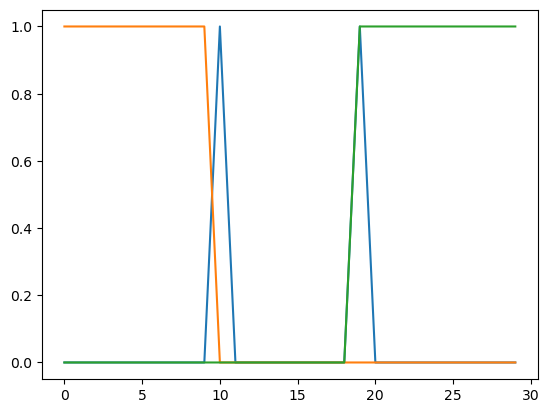

In [66]:

rng = jax.random.PRNGKey(0)
done = jax.random.uniform(rng, (30, )) < 0.10
plt.plot(done)
plt.plot(done.cumsum()==0)
plt.plot(done.cumsum()==done.sum())
# print(done)


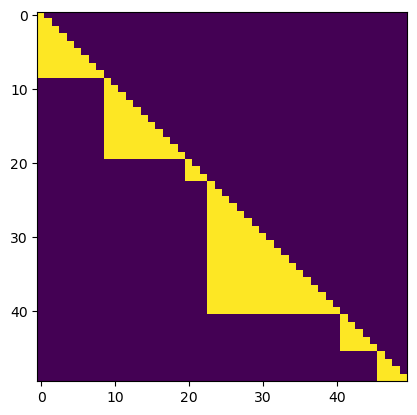

In [51]:
def make_attn_mask(done):
    T, = done.shape
    mask_causal = jnp.tril(jnp.ones((T, T), dtype=bool))
    y, x = jnp.arange(T)[:, None], jnp.arange(T)[None, :]
    def single_causal_done_mask(mask, i):
        mask_done = ~((y>=i) * (x<i))
        mask_done = jax.lax.select(done[i], mask_done, mask_causal)
        return mask * mask_done, None
    mask, _ = jax.lax.scan(single_causal_done_mask, mask_causal, jnp.arange(T))
    return mask

a = make_attn_mask(done)
plt.imshow(a)

In [26]:
from agents.linear_transformer import make_attn_mask

In [90]:
def linear_attention_resets(state, qkvdone):  # state: D, D; qkv: T, D; done: T
    (q, k, v), done = qkvdone
    done_any, done_before_first, done_after_last = done.any(), done.cumsum() == 0, done.cumsum() == done.sum()
    q_bef = q * done_before_first[:, None]
    k_aft = k * done_after_last[:, None]
    v_aft = v * done_after_last[:, None]
    mask = make_attn_mask(done)  # T, T
    attn = mask * (q @ k.T)
    out = attn @ v + q_bef @ state
    state = jax.lax.select(done_any, k_aft.T @ v_aft, state + k_aft.T @ v_aft)
    return state, out


In [91]:
rng = jax.random.PRNGKey(0)
B, T, D = 16, 30, 32

done = jax.random.uniform(rng, (T, )) < 0.10
rng, _rng = split(rng)
state = jax.random.normal(_rng, (D, D))
rng, _rng = split(rng)
q, k, v = jax.random.normal(_rng, (3, T, D))

state1, out1 = linear_attention_resets(state, ((q, k, v), done))
# print(jax.tree_map(lambda x: x.shape, (state1, out1)))

q, k, v, done = jax.tree_map(lambda x: rearrange(x, 'T ... -> T 1 ...'), (q, k, v, done))
state2, out2 = jax.lax.scan(linear_attention_resets, state, ((q, k, v), done))
out2 = rearrange(out2, 'T 1 D -> T D')
# print(jax.tree_map(lambda x: x.shape, (state2, out2)))

jax.tree_map(lambda x, y: jnp.allclose(x, y, atol=1e-4).item(), (state1, out1), (state2, out2))


(True, True)

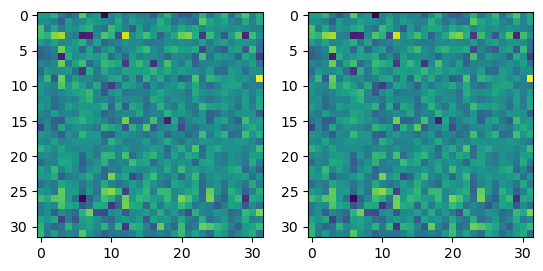

In [73]:
plt.subplot(121)
plt.imshow(state1)
plt.subplot(122)
plt.imshow(state2)


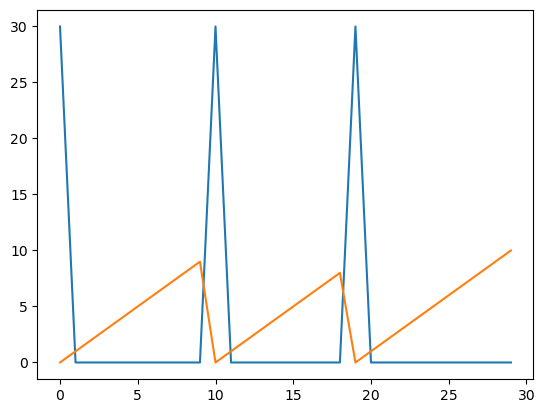

In [130]:
done = done.at[0].set(True)
plt.plot(done*30)
a = jnp.arange(5, 35)
plt.plot(a-jax.lax.associative_scan(jnp.maximum, a*done))


